# 2. Entrenamiento de RNNs en una Serie de Tiempo

**2.0 Imports necesarios**

In [129]:
import pandas
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

**2.1 Creación de conjuntos de entrenamiento y prueba**

En primer lugar, se crean los conjuntos de entrenamiento y de prueba por medio de la función *create_sets*. Esta función también se encarga de escalar los datos de cada conjunto. El dataset original está compuesto por un total de 144 registros, de los cuales 96 estarán destinados a conformar el conjunto de entrenamiento, mientras que los 48 restantes formarán parte del conjunto de pruebas.

In [130]:
# Función para la creación de conjuntos de entrenamiento y prueba
def create_sets(file_name):
    # Se lee archivo que contiene todos los datos
    dataframe = pandas.read_csv(file_name, sep=',', usecols=[1], engine='python', skipfooter=3)
    # Se utiliza precisión de 32 bits para atributos numéricos
    dataframe[:] = dataframe[:].astype('float32')
    # Se crean conjuntos de entrenamiento y de prueba
    df_train, df_test = dataframe[0:96].values, dataframe[96:].values
    # Se escalan los datos de cada conjunto
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
    stream_train_scaled = scaler.transform(df_train)
    stream_test_scaled = scaler.transform(df_test)
    return scaler, list(stream_train_scaled), list(stream_test_scaled)

# Se crean conjuntos a partir de archivo .csv
scaler, train_set, test_set = create_sets('international-airline-passengers.csv')

**2.2 Generación de atributos predictores y atributo a predecir**

Ya creados los conjuntos de entrenamiento y de prueba, se procede a construir, para cada caso, la matriz X y el vector Y. La matriz X contendrá, para cada registro, la cantidad de pasajeros en los tiempos x(t-2), x(t-1) y x(t), o en otras palabras, los atributos predictores. Por otro lado, el vector Y almacenará en la casilla correspondiente la cantidad de pasajeros en el tiempo x(t+1), es decir, el atributo a predecir. El procedimiento descrito será llevado a cabo por medio de la función *create_dataset*.

In [137]:
# Función encargada de separar valores predictores y valores a predecir
def create_dataset(sequence, lag):
    dataX = []
    dataY = []
    for i in range(lag, len(sequence)):
        # Se crea matriz X
        dataX.append(sequence[i - lag : i])
        # Se crea vector Y
        dataY.append(sequence[i])
    return np.array(dataX), np.array(dataY)

Así, se crea la matriz X y el vector Y en base a los conjuntos de entrenamiento y de prueba. Se utilizará lag = 3, en primera instancia.

In [138]:
# Inicialmente, se usará lag = 3
lag = 3
# Se crea matriz X y vector Y en base a conjuntos de entrenamiento y prueba
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)

In [140]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

De esta forma, la matriz X poseen dimensiones (número de ejemplos, time step, número de atributos predictores) tanto para el caso de entrenamiento como para el caso de pruebas.

**2.3 Entrenamiento de red LSTM**

A partir de las matrices creadas en la sección anterior, se entrena y posteriormente se evalúa una red LSTM. Recordar que se está utilizando un lag de 3.

In [141]:
model = Sequential()
model.add(LSTM(4, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1)

Epoch 1/100
93/93 [==============================] - 0s - loss: 0.1007     
Epoch 2/100
93/93 [==============================] - 0s - loss: 0.0375     
Epoch 3/100
93/93 [==============================] - 0s - loss: 0.0217     
Epoch 4/100
93/93 [==============================] - 0s - loss: 0.0184     
Epoch 5/100
93/93 [==============================] - 0s - loss: 0.0165     
Epoch 6/100
93/93 [==============================] - 0s - loss: 0.0147     
Epoch 7/100
93/93 [==============================] - 0s - loss: 0.0134     
Epoch 8/100
93/93 [==============================] - 0s - loss: 0.0124     
Epoch 9/100
93/93 [==============================] - 0s - loss: 0.0115     
Epoch 10/100
93/93 [==============================] - 0s - loss: 0.0110     
Epoch 11/100
93/93 [==============================] - 0s - loss: 0.0108     
Epoch 12/100
93/93 [==============================] - 0s - loss: 0.0102     
Epoch 13/100
93/93 [==============================] - 0s - loss: 0.0100     
Epoch 14

**2.4 Determinación de error y de prueba**

...

In [142]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

...

In [144]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Error de entrenamiento: 22.6987545798 RMSE
Error de prueba: 66.6861161407 RMSE


...

**2.5 Comparación de predicciones**

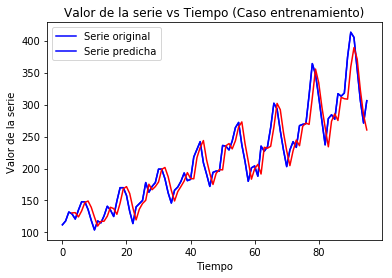

In [145]:
plt.plot(range(len(train_set)), scaler.inverse_transform(train_set), 'b')
plt.plot(range(len(train_set))[lag:], list(trainPredict), 'r')
plt.title('Valor de la serie vs Tiempo (Caso entrenamiento)')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la serie')
plt.legend(['Serie original', 'Serie predicha'], loc='best')
plt.show()

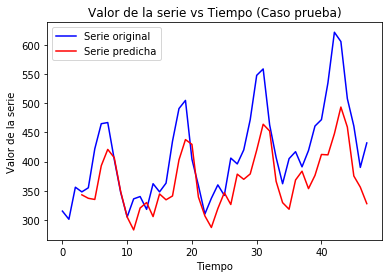

In [147]:
plt.plot(range(len(test_set)), scaler.inverse_transform(test_set), 'b')
plt.plot(range(len(test_set))[lag:], list(testPredict), 'r')
plt.title('Valor de la serie vs Tiempo (Caso prueba)')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la serie')
plt.legend(['Serie original', 'Serie predicha'], loc='best')
plt.show()

...